<a href="https://colab.research.google.com/github/kchiem12/EchoAI/blob/main/EchoAI_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Setup

In [ ]:
import numpy as np
from keras.utils import to_categorical
import tensorflow.keras.backend as K
from keras import Sequential
from keras.layers import Dropout, LSTM, Dense, Activation, TimeDistributed, BatchNormalization
from keras.regularizers import l2
from keras.callbacks import ModelCheckpoint, EarlyStopping
import random
from music21 import converter, instrument, note, chord, stream
import pickle
import pandas as pd
import os
import matplotlib.pyplot as plt

#Mounting

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Preprocess Data

In [ ]:
songs = []

# Folder containing raw midis
folder = './drive/MyDrive/data'

# Go thru folder and append song to notes array
for root, dirs, files in os.walk(folder):
    for file in files:
        if file.endswith('.midi'):
            songs.append(os.path.join(root, file))

number_of_items = len(songs)
print(f"Number of items in folder: {number_of_items}")

Number of items in folder: 5


In [ ]:
result = []

def parse_raw_midis():
  for i, file in enumerate(songs):
      print(f'Parsing file {i + 1}: {file}')

      try:
          midi = converter.parse(file)
          parse = None
          parts = instrument.partitionByInstrument(midi)

          # If there are parts get the notes from the first part
          if parts:
              parse = parts.parts[0].recurse()
          else:
              parse = midi.flat.notes

          for curr in parse:
              if isinstance(curr, note.Note):
                  result.append(str(curr.pitch))
              elif isinstance(curr, chord.Chord):
                  result.append('.'.join(str(n) for n in curr.normalOrder))
      except:
          print(f'Error parsing at file {i + 1}: {file}')

parse_raw_midis()
print("Success!")

Success!


##Save preprocessed data to disk

In [ ]:
with open('./drive/MyDrive/CS4701/notes', 'wb') as filepath:
  pickle.dump(result, filepath)

#Load preprocessed data

In [ ]:
notes = None
file_path = './drive/MyDrive/CS4701/notes_new'

with open(file_path, 'rb') as file:
    file_content = file.read()

print(f"File content length: {len(file_content)} bytes")
print(file_content[:100])

try:
    with open(file_path, 'rb') as file:
        buffer = []
        while True:
            try:
                buffer.append(pickle.load(file))
            except EOFError:
                break
    notes = buffer
    print("Loaded successfully.")
except EOFError:
    print("EOFError: The file might be incomplete.")
except pickle.UnpicklingError:
    print("UnpicklingError: The file might be corrupted.")
except Exception as e:
    print(f"Unexpected error: {e}")

# Flatten the list if it contains nested lists
flat_notes = []

for item in notes:
    if isinstance(item, list):
        flat_notes.extend(item)
    else:
        flat_notes.append(item)

print(flat_notes[:1000])
print(len(flat_notes))

File content length: 23275087 bytes
b'\x80\x04\x95\x01\x00\x01\x00\x00\x00\x00\x00]\x94(\x8c\x039.2\x94\x8c\x02D4\x94\x8c\x03F#4\x94\x8c\x039.2\x94\x8c\x02A4\x94\x8c\x03F#4\x94\x8c\x039.2\x94\x8c\x02D5\x94\x8c\x02A4\x94\x8c\x039.2\x94\x8c\x03F#5\x94\x8c\x02D5\x94\x8c\x039.2\x94\x8c\x02D6\x94\x8c\x02A5\x94\x8c\x039'
Loaded successfully.
['9.2', 'D4', 'F#4', '9.2', 'A4', 'F#4', '9.2', 'D5', 'A4', '9.2', 'F#5', 'D5', '9.2', 'D6', 'A5', '9.2', '0.2.4', '5.6.7.9', '9.11', '9.1.2', '4.6.7', '7.9', '7.11.1', '2.4.6', '2.6.7', '9.11.4', '1.2.6', '2.4', '6.7', 'A5', '9', '9.11.1', '2.4.7', '6.7', '7.9.11', '1.2.6', '2.4.6', '4.7.9', '11.1', '6.7.9', 'D5', 'B5', 'A5', 'F#4', '4.7', '2.6.9', '9.1.4', 'D4', '6.7.9', 'B5', '6.9', 'D4', '6.9', 'F#3', '4.7', '2.6.9', '9.1.4', '2', '2', '2', '2.7', 'B3', '2.7', '2.6.7', '2.6', 'A3', '2.6', '2.6', '2.4.6', 'G3', '2.4', '2.4', '2.6', '2', 'F#3', '2', '2.6', '2.7', 'B3', '2.7', '2.7', '2.6', 'A3', '2.6', '2.6', '2.4.6', 'G3', '2.4', '2.4', '2.6', 'F#3', 

# Sequence creation

In [ ]:
def prepare_sequences(notes, num_vocab, seq_length):
    pitch_set = sorted(set(notes))
    pitch_to_int = {pitch: idx for idx, pitch in enumerate(pitch_set)}

    inputs, outputs = [], []

    for i in range(0, len(notes) - seq_length, 1):
        input_seq = notes[i:i + seq_length]
        output_seq = notes[i + seq_length]

        inputs.append([pitch_to_int[pitch] for pitch in input_seq])
        outputs.append(pitch_to_int[output_seq])

    num_patterns = len(inputs)

    # Reshape and normalize input sequences
    inputs = np.reshape(inputs, (num_patterns, seq_length, 1))
    inputs = inputs / float(num_vocab)

    # One hot encode output sequences
    outputs = to_categorical(outputs, num_classes=num_vocab)

    return inputs, outputs

num_vocab = len(set(flat_notes[:50000]))
network_input, network_output = prepare_sequences(flat_notes[:50000], num_vocab, 64)
pitchnames = sorted(set(item for item in flat_notes[:50000]))

# Model / Training

In [ ]:
class EchoAI_LSTM:
    def __init__(self, input_shape, num_vocab):
        self.input_shape = input_shape
        self.num_vocab = num_vocab
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(LSTM(
            1024,
            input_shape=self.input_shape,
            return_sequences=True
        ))
        model.add(LSTM(1024, return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(1024))
        model.add(Dense(1024))
        model.add(Dropout(0.3))
        model.add(Dense(self.num_vocab))
        model.add(Activation('softmax'))
        return model

    def compile_model(self, loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy']):
        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)

    def summary(self):
        self.model.summary()

    def train(self, network_input, network_output, epochs=50, batch_size=64, validation_split=0.2, callbacks=None):
        history = self.model.fit(network_input, network_output, epochs=epochs,
                                 batch_size=batch_size, validation_split=validation_split, callbacks=callbacks)
        return history

    def evaluate(self, test_input, test_output):
        return self.model.evaluate(test_input, test_output)

    def predict(self, input_data):
        return self.model.predict(input_data, verbose=0)

input_shape = (network_input.shape[1], network_input.shape[2])

lstm = EchoAI_LSTM(input_shape, num_vocab)
lstm.compile_model()
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_6 (LSTM)               (None, 64, 1024)          4202496   
                                                                 
 lstm_7 (LSTM)               (None, 64, 1024)          8392704   
                                                                 
 dropout_4 (Dropout)         (None, 64, 1024)          0         
                                                                 
 lstm_8 (LSTM)               (None, 1024)              8392704   
                                                                 
 dense_4 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_5 (Dropout)         (None, 1024)              0         
                                                                 
 dense_5 (Dense)             (None, 967)              

In [ ]:
num_epochs = 100

filepath = "./weights/weights-improvement-{epoch:02d}-{loss:.4f}-bigger_1.h5"
checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor='val_accuracy',
    verbose=0,
    save_best_only=True,
    mode='min'
)

callbacks_list = [checkpoint]

model = lstm.train(network_input, network_output, epochs=num_epochs, validation_split=0.2, batch_size=512, callbacks=callbacks_list)

Epoch 1/100
79/79 [==============================] - 12s 94ms/step - loss: 5.6773 - accuracy: 0.0136 - val_loss: 5.6928 - val_accuracy: 0.0129
Epoch 2/100
79/79 [==============================] - 6s 71ms/step - loss: 5.4346 - accuracy: 0.0164 - val_loss: 5.2657 - val_accuracy: 0.0141
Epoch 3/100
79/79 [==============================] - 6s 70ms/step - loss: 5.3363 - accuracy: 0.0188 - val_loss: 7.2687 - val_accuracy: 0.0157
Epoch 4/100
79/79 [==============================] - 6s 70ms/step - loss: 5.4934 - accuracy: 0.0188 - val_loss: 5.0152 - val_accuracy: 0.0252
Epoch 5/100
79/79 [==============================] - 6s 79ms/step - loss: 5.2924 - accuracy: 0.0193 - val_loss: 5.1532 - val_accuracy: 0.0043
Epoch 6/100
79/79 [==============================] - 6s 70ms/step - loss: 5.2785 - accuracy: 0.0203 - val_loss: 5.0730 - val_accuracy: 0.0164
Epoch 7/100
79/79 [==============================] - 6s 70ms/step - loss: 5.5734 - accuracy: 0.0202 - val_loss: 5.0492 - val_accuracy: 0.0132
Epoch

In [ ]:
lstm.model.save('./drive/MyDrive/Models/echoai_lstm_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


#Results

Min loss 8.988272905349731 at 58


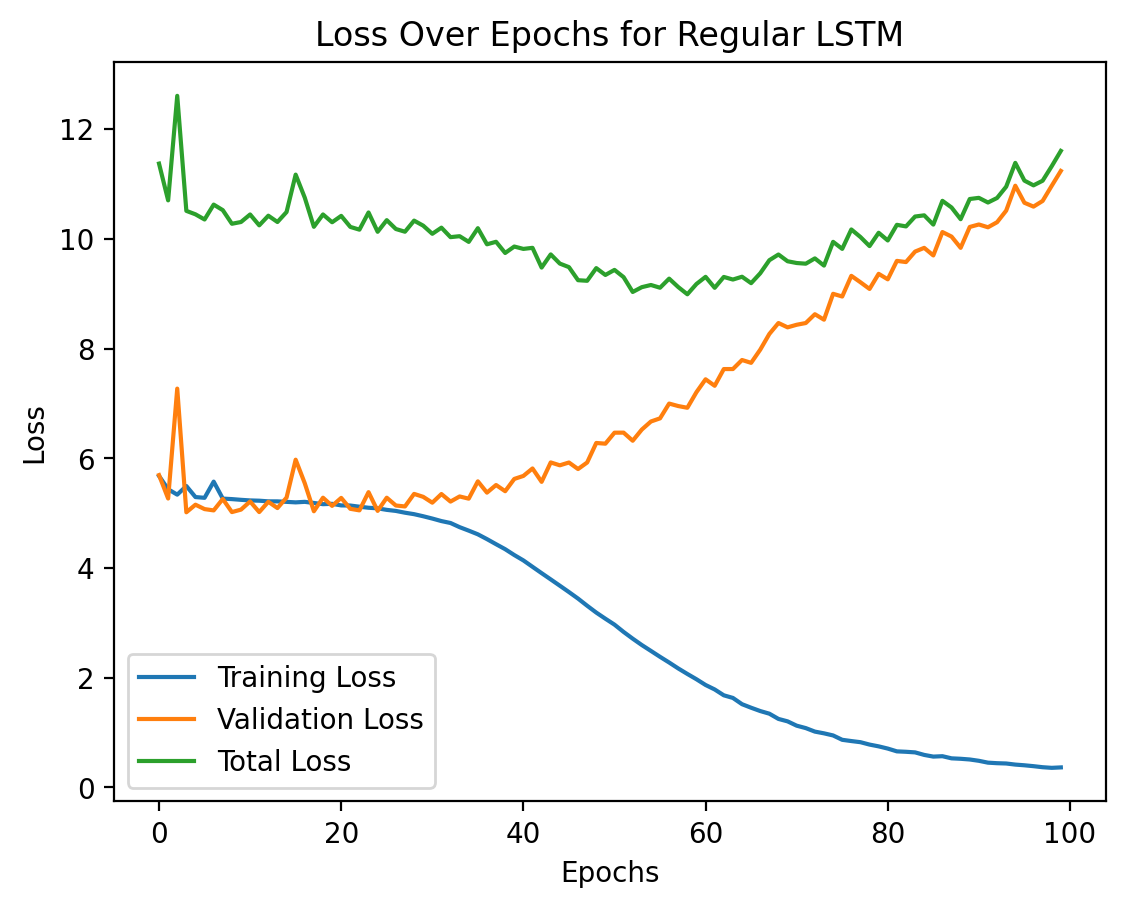

In [ ]:
total_loss = [train + val for train, val in zip(model.history['loss'], model.history['val_loss'])]

min_total_loss = min(total_loss)
min_epoch = total_loss.index(min_total_loss)
print(f"Min loss {min_total_loss} at {min_epoch}")

plt.plot(model.history['loss'], label='Training Loss')
plt.plot(model.history['val_loss'], label='Validation Loss')
plt.plot(total_loss, label='Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs for Regular LSTM')
plt.legend()
plt.show()

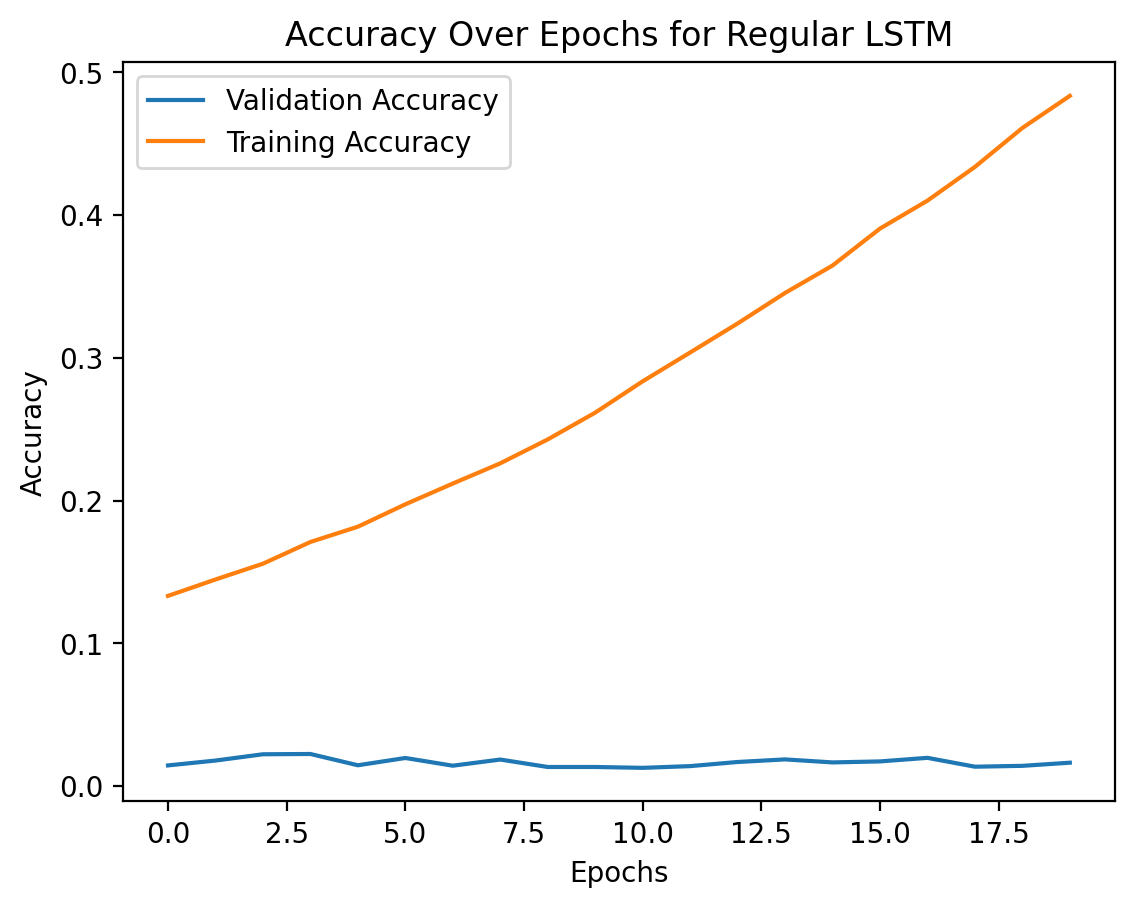

In [ ]:
plt.plot(model.history['val_accuracy'], label='Validation Accuracy')
plt.plot(model.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs for Regular LSTM')
plt.legend()
plt.show()

# Create predictions

In [ ]:
def sample_with_temperature(predictions, temperature=1.0):
    predictions = np.asarray(predictions).astype('float64')

    if temperature==0.0:
      return np.argmax(predictions)

    predictions = np.log(predictions + 1e-9) / temperature
    exp_predictions = np.exp(predictions)
    predictions = exp_predictions / np.sum(exp_predictions)
    probas = np.random.multinomial(1, predictions, 1)
    return np.argmax(probas)

def generate_notes(model, network_input, pitchnames, num_vocab, temperature=1.0):
    start = np.random.randint(0, len(network_input)-1)
    int_to_note = dict((number, note)for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    output = []

    for note_index in range(100):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))

        prediction = model.predict(prediction_input)
        index = sample_with_temperature(prediction[0], temperature)
        result = int_to_note[index]
        output.append(result)

        # Update the pattern
        pattern = np.append(pattern, (index / float(num_vocab)))
        pattern = pattern[1:]

    return output

num_vocab = len(set(flat_notes[:50000]))
pitchnames = sorted(set(item for item in flat_notes[:50000]))
output = generate_notes(lstm, network_input, pitchnames, num_vocab, temperature=1)

In [ ]:
print(output)

['C3', 'E4', 'E4', 'E4', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'G#3', 'D3', 'D3', '2.8', '2.8', '2.8', 'G#3', 'B-4', 'B-4', 'B-4', 'F4', 'G3', 'E3', 'E3', 'E3', 'E3', 'E3', 'E3', 'E3', 'C4', 'C#2', '0.5', 'F3', 'C#5', 'C#3', 'F4', 'C#4', 'C#4', 'A4', 'A4', 'D3', 'D4', 'D4', 'D5', 'D4', 'A5', 'D5', '7.9', '7.9', '7.9', '7.9', 'B4', 'C5', 'C#5', 'A2', 'A2', 'A1', 'A1', 'A1', 'A1', 'D3', '3.6.9.11', 'A3', '4.8', '11.3', '4.8', '4.8', '11.3', '11.3', 'F#5', '3', '3', '3', '3', '3', '1.3.5', '1.3.5', 'G3', 'G3', '1.4.8', '3.4.8.11', '3.7.10', '3.7.10', '8.11.2', '8.11.2', 'B4', 'B-4', 'B-4', 'B-4', '1.3', '8.11', 'B-4', 'B-4', '1.3', '1.3', 'E-2', 'G#4', '3', 'G#4']


In [ ]:
def create_midi(output):
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp='output.mid')

create_midi(output)